A 250-hPa Hemispheric Map using Python
======================================

This example plots a hemispheric plot of GFS 250-hPa Geopotential Heights and
wind speed in knots.

In the first code block we retrieve the latest weather data from the [Global Forecast System](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast). First we import the various packages we need:
* `datetime` provides support for dates and times
* `cartopy` and `matplotlib` are used for making the plot at the end of the notebook
* [`siphon`](https://unidata.github.io/siphon/latest/index.html) provides support for downloading data hosted on a [THREDDS Data Server](https://www.unidata.ucar.edu/software/tds/current/)
* `metpy` provides some utilities for handling meteorological data
* `xarray` provides support for working with multidimensional arrays and datasets
Uncomment the two `print` statements at the end of the code block to see the URL and the variables the dataset contains. 

In [1]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from xarray.backends import NetCDF4DataStore
import xarray as xr

# Latest GFS Dataset
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/latest.xml')
best_ds = list(cat.datasets.values())[0]

ncss = NCSS(best_ds.access_urls['NetcdfSubset'])
# print(best_ds.access_urls['NetcdfSubset'])
# print(ncss.variables)

The dataset contains forecast data starting from the 0 hour forecast, every 3 hours out to 10 days, then 12 hour forecasts for days 10-16. We can retrieve data for a specific time point by querying the `siphon.ncss` object. In the following code block we create a `datetime` object for the specific forecast time we would like to visualize. Try adjusting the `days` and `hours` arguments to `timedelta`.

In [2]:
# Set the time to current
forecast_time = datetime.utcnow() + timedelta(days=1, hours=3)
print(forecast_time)

2021-10-08 11:24:39.412526


In [3]:
# Query for Latest GFS Run
gfsdata_hght = ncss.query().time(forecast_time).accept('netcdf4')
gfsdata_hght.variables('Geopotential_height_isobaric').add_lonlat()

# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
gfsdata_hght.lonlat_box(0, 360, 0, 90)

# Set desired level 50000 = 50000 Pa = 500 hPa
gfsdata_hght.vertical_level(25000)

# Actually getting the data
data_hght = ncss.get_data(gfsdata_hght)

# Make into an xarray Dataset object
ds_hght = xr.open_dataset(NetCDF4DataStore(data_hght)).metpy.parse_cf()

# Query for Latest GFS Run
gfsdata_wind = ncss.query().time(forecast_time).accept('netcdf4')
gfsdata_wind.variables('u-component_of_wind_isobaric',
                       'v-component_of_wind_isobaric').add_lonlat()

# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
gfsdata_wind.lonlat_box(0, 360, 0, 90)

# Set desired level 50000 = 50000 Pa = 500 hPa
gfsdata_wind.vertical_level(25000)

# Actually getting the data
data_wind = ncss.get_data(gfsdata_wind)

# Make into an xarray Dataset object
ds_wind = xr.open_dataset(NetCDF4DataStore(data_wind)).metpy.parse_cf()
print(ds_wind)

<xarray.Dataset>
Dimensions:                       (time19: 1, isobaric1: 1, lat: 181, lon: 720)
Coordinates:
  * time19                        (time19) datetime64[ns] 2021-10-08T12:00:00
  * isobaric1                     (isobaric1) float32 2.5e+04
  * lat                           (lat) float32 90.0 89.5 89.0 ... 1.0 0.5 0.0
  * lon                           (lon) float32 0.0 0.5 1.0 ... 359.0 359.5
    metpy_crs                     object Projection: latitude_longitude
Data variables:
    v-component_of_wind_isobaric  (time19, isobaric1, lat, lon) float32 ...
    LatLon_Projection             int32 ...
    u-component_of_wind_isobaric  (time19, isobaric1, lat, lon) float32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                 

The next cell will take the downloaded data and parse it to different variables
for use later on. Add a cyclic point using the cartopy utility add_cyclic_point
to the longitudes (the cyclic dimension) as well as any data that is being
contoured or filled.

In [4]:
dtime = ds_hght.Geopotential_height_isobaric.dims[0]
lat = ds_hght.lat.values
lon = ds_hght.lon.values

# Converting times using the num2date function available through netCDF4
vtimes = ds_hght[dtime].values.astype('datetime64[ms]').astype('O')

# Smooth the 250-hPa heights using a gaussian filter from scipy.ndimage
hgt = ds_hght.Geopotential_height_isobaric.squeeze()
hgt_250, lon = cutil.add_cyclic_point(hgt, coord=lon)

Z_250 = mpcalc.smooth_n_point(hgt_250, 9, 2)

# Calculate wind speed from u and v components, add cyclic point,
# and smooth slightly
u250 = ds_wind['u-component_of_wind_isobaric'].squeeze()
v250 = ds_wind['v-component_of_wind_isobaric'].squeeze()

wspd250 = mpcalc.wind_speed(u250, v250).metpy.convert_units('knots')
wspd250 = cutil.add_cyclic_point(wspd250)

smooth_wspd250 = mpcalc.smooth_n_point(wspd250, 9, 2)

The next cell sets up the geographic details for the plot that we are going to do later.
This is done using the Cartopy package. We will also bring in some geographic data to
geo-reference the image for us.

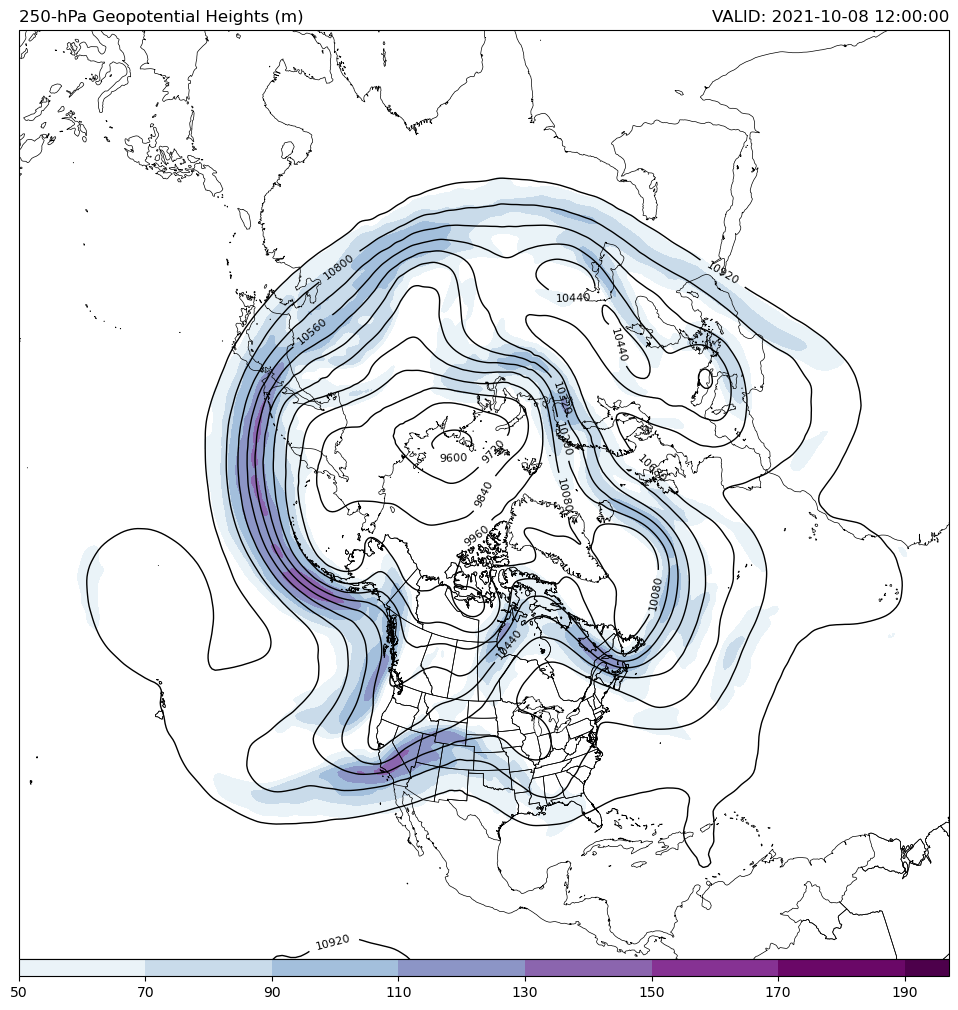

In [5]:
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.NorthPolarStereo(central_longitude=-100.0)

# Make a grid of lat/lon values to use for plotting.
lons, lats = np.meshgrid(lon, lat)

fig = plt.figure(1, figsize=(12., 15.))
ax = plt.subplot(111, projection=plotcrs)

# Set some titles for the plots
ax.set_title('250-hPa Geopotential Heights (m)', loc='left')
ax.set_title(f'VALID: {vtimes[0]}', loc='right')

# Set the extent of the image for the NH and add
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-180, 180, 10, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black',
               linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)

# Add geopotential height contours every 120 m
clev250 = np.arange(9000, 12000, 120)
cs = ax.contour(lons, lats, Z_250, clev250, colors='k',
                linewidths=1.0, linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Add colorfilled wind speed in knots every 20 kts
clevsped250 = np.arange(50, 200, 20)
cmap = plt.cm.get_cmap('BuPu')
cf = ax.contourf(lons, lats, smooth_wspd250, clevsped250, cmap=cmap,
                 extend='max', transform=datacrs)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50,
                    extendrect=True)
plt.show()
